In [1]:
import os
import cmocean
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import netCDF4 as netcdf
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString

from concorde.plots import plot2D
from concorde.tools import get_list

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore")

In [4]:
dfMax

,x,y,zeta_max
0000,-76.737441,35.356003,6.464966
0001,-78.756484,33.778052,1.425744
0002,-76.415619,34.926268,1.848535
0003,-75.905511,36.661050,1.721653
0004,-77.953116,34.213106,1.375811
...,...,...,...
1810,-76.415619,34.926268,2.071285
1811,-78.770641,33.770306,1.361146
1812,-76.564359,34.955957,2.303996
1813,-78.646273,33.857048,3.735695


In [5]:
pathin = Path(r'/media/tacuevas/Extreme SSD/batch02')
runs = sorted(get_list(pathin, ends = 'maxele.63.nc'))
runs = [os.path.dirname(x).split('/')[-1] for x in runs]

pathout = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_maxplots')

path_tracks = Path(r'../data/STORM/processed/batch02')
dfTracks = pd.read_pickle(path_tracks/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

dfMax = pd.read_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/max_water_level_NC.pkl')
# dfMaxSorted = (dfMax
#                .sort_values('zeta_max', ascending = False)
#                .drop('base', axis = 0)
#                 )

# for irun, run in tqdm(enumerate(dfMaxSorted.index)):
for irun, run in tqdm(enumerate(dfMax.index)):

    pathRun = pathin/run

    try:
        os.mkdir(pathout/run)
    except:
        pass

    f1 = pathRun/'maxele.63.nc'
    f2 = pathRun/'maxwvel.63.nc'
    ## read files
    nc1 = netcdf.Dataset(f1, 'r')
    nc2 = netcdf.Dataset(f2, 'r')
    
    ## track
    storm = dfTracks[dfTracks['runIndex'] == int(run)]

    cmap = cmocean.cm.speed
    norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)
    fig, ax = plt.subplots(figsize = (8, 8), nrows = 2, ncols = 2, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

    ##### subplot 0, 0
    ## 2D water level plot
    plot2D(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = False, fig = fig, ax = ax[0, 0], cmap = 'viridis')
    ## track
    ax[0, 0].plot(storm['lon'], storm['lat'], color = 'k', alpha = 0.5)
    ## storm's eye colored by category
    ax[0, 0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ## storm genesis
    ax[0, 0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 100)
    ## NC box
    ax[0, 0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'r', linewidth = 0.4)
    ax[0, 0].scatter(dfMax.loc[run, 'x'], dfMax.loc[run, 'y'], c = 'r', marker = '.')

    gl = ax[0, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([-95, -85, -75, -65])
    ax[0, 0].add_feature(cfeature.LAND)
    ax[0, 0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 0].add_feature(cfeature.LAKES)

    fig = ax[0, 0].get_figure()
    cax = fig.add_axes([0.25, -0.02, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'Saffir - Simpson Wind Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))

    ##### subplot 0, 1
    plot2D(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = True, fig = fig, ax = ax[0, 1], cmap = 'viridis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cb_label = 'Max water level [m MSL]', cb_shrink = 0.8)
    ax[0, 1].plot(storm['lon'], storm['lat'], color = 'k', alpha = 0.5)
    ax[0, 1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ax[0, 1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 100)
    ax[0, 1].scatter(dfMax.loc[run, 'x'], dfMax.loc[run, 'y'], c = 'r', marker = '.')
    ax[0, 1].add_feature(cfeature.LAND)
    ax[0, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 1].add_feature(cfeature.LAKES)

    gl = ax[0, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[0, 1].add_feature(cfeature.LAND)
    ax[0, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 1].add_feature(cfeature.LAKES)

    ##### subplot 1, 0
    plot2D(nc2, 'wind_max', np.arange(0, 90, 10), cbar = False, fig = fig, ax = ax[1, 0], cmap = 'cividis')
    ax[1, 0].plot(storm['lon'], storm['lat'], color = 'k', alpha = 0.5)
    ax[1, 0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ax[1, 0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 100)
    ax[1, 0].scatter(dfMax.loc[run, 'x'], dfMax.loc[run, 'y'], c = 'r', marker = '.')
    ax[1, 0].add_feature(cfeature.LAND)
    ax[1, 0].add_feature(cfeature.COASTLINE,lw = 0.25)
    ax[1, 0].add_feature(cfeature.LAKES)
    ax[1, 0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'r', linewidth = 0.4)
    ax[1, 0].scatter(dfMax.loc[run, 'x'], dfMax.loc[run, 'y'], c = 'r', marker = '.')

    gl = ax[1, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([-95, -85, -75, -65])
    ax[1, 0].add_feature(cfeature.LAND)
    ax[1, 0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 0].add_feature(cfeature.LAKES)

    ##### subplot 1, 1
    plot2D(nc2, 'wind_max', np.arange(0, 90, 10), cbar = True, fig = fig, ax = ax[1, 1], cmap = 'cividis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cb_label = 'Max wind speed [m/s]', cb_shrink = 0.8)
    ax[1, 1].plot(storm['lon'], storm['lat'], color = 'k', alpha = 0.5)
    ax[1, 1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ax[1, 1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 100)
    ax[1, 1].scatter(dfMax.loc[run, 'x'], dfMax.loc[run, 'y'], c = 'r', marker = '.')
    ax[1, 1].add_feature(cfeature.LAND)
    ax[1, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 1].add_feature(cfeature.LAKES)

    gl = ax[1, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[1, 1].add_feature(cfeature.LAND)
    ax[1, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 1].add_feature(cfeature.LAKES)

    # text1 = f"Storm: {info['Storm_id'].iloc[0]:0d}\nP NC: {info['min_press_at_min_distNC'].iloc[0]:.0f} hPa\nP: {info['min_press_at_min_press'].iloc[0]:.0f} hPa\n"
    # text2 = f"WS NC: {info['max_ws_at_min_distNC'].iloc[0]/3.6:0.1f} km/hr\nRMW: {info['rad_to_max_ws_at_min_distNC'].iloc[0]:.1f} km\n"
    # text3 = f"F speed: {info['forward_speed_at_min_distNC'].iloc[0]/3.6:0.1f} km/hr\nDur {info['New_duration'].iloc[0]/3.6:.1f} d"
    # anchored_text = AnchoredText(text1 + text2 + text3, loc = 'lower left', prop=dict(size=8))
    # ax[0, 0].add_artist(anchored_text)

    fig.suptitle(f'Run {run}', fontsize = 16)
    plt.savefig(pathout/run/f'{run}.jpg', dpi = 300, bbox_inches = 'tight')
    plt.close()

    break

0it [00:17, ?it/s]


In [3]:
run

'0249'

In [6]:
#path = Path(r'/mnt/drive1/Thesis/models/adcirc/concorde_NC9')
# path = Path(r'D:\TCL\ncsu\thesis\adcirc_results')


pathin = Path(r'/media/tacuevas/SSD_tomas/thesis/adcirc/batch01/_max_results')
pathout = Path(r'../models/adcirc/concorde_NC9/postprocess')
pathout = pathout/'maxplots'

dfinfo = pd.read_csv(r'../models/adcirc/concorde_NC9/simulations_info_parameters.csv', index_col = 0)

#path_tracks = Path(r'/mnt/drive1/Thesis/data/STORM/processed')
path_tracks = Path(r'../data/STORM/processed')
tracks = pd.read_pickle(path_tracks/'STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000_map_original_ts_v3_reducedLength.pkl')
dfnts = tracks.groupby(by = 'run_index')['time_step2'].max()


nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

for x in tqdm([f'{x:03d}' for x in dfnts[dfnts > 96].index]):

    run = pathin/x
    f1 = run/'maxele.63.nc'
    f2 = run/'maxwvel.63.nc'
    nc1 = netcdf.Dataset(f1, 'r')
    nc2 = netcdf.Dataset(f2, 'r')
    storm = tracks[tracks['run_index'] == int(x)]
    info = dfinfo[dfinfo.index == int(x)]

    gdf_track = gpd.GeoDataFrame(geometry = [LineString([[x1, y1], [x2, y2]]) for x1, y1, x2, y2 in zip(storm['lon'].iloc[:-1], 
                                                                                                   storm['lat'].iloc[:-1], 
                                                                                                   storm['lon'].iloc[1:], storm['lat'].iloc[1:])])
    gdf_track['cat'] = storm['cat'].iloc[1:].values
    cmap = plt.cm.plasma_r
    #     norm = colors.BoundaryNorm(np.arange(0, storm['cat'].max() + 2, 1), cmap.N)
    norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)
    fig, ax = plt.subplots(figsize = (8, 8), nrows = 2, ncols = 2, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

    ##### subplot 0, 0
    plot2D(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = False, fig = fig, ax = ax[0, 0], cmap = 'viridis')
    box.boundary.plot(ax = ax[0, 0], color = 'k', ls = '--')
    gdf_track.plot(ax = ax[0, 0], color = 'k', alpha = 0.5)
    ax[0, 0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 20)
    ax[0, 0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*')
    ax[0, 0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'r', linewidth = 0.4)

    gl = ax[0, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[0, 0].add_feature(cfeature.LAND)
    ax[0, 0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 0].add_feature(cfeature.LAKES)

    ##### subplot 0, 1
    plot2D_v2(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = True, fig = fig, ax = ax[0, 1], cmap = 'viridis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cax = ax[0, 1], cb_label = 'Max water level [m MSL]')
    gdf_track.plot(ax = ax[0, 1], color = 'k', alpha = 0.5)
    ax[0, 1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 20)
    ax[0, 1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*')
    ax[0, 1].add_feature(cfeature.LAND)
    ax[0, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 1].add_feature(cfeature.LAKES)

    gl = ax[0, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[0, 1].add_feature(cfeature.LAND)
    ax[0, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0, 1].add_feature(cfeature.LAKES)

    fig = ax[0, 0].get_figure()
    cax = fig.add_axes([0.25, -0.02, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'Saffir - Simpson Wind Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))

    ##### subplot 1, 0
    plot2D(nc2, 'wind_max', np.arange(0, 90, 10), cbar = False, fig = fig, ax = ax[1, 0], cmap = 'cividis')
    box.boundary.plot(ax = ax[1, 0], color = 'k', ls = '--')
    gdf_track.plot(ax = ax[1, 0], color = 'k', alpha = 0.5)
    ax[1, 0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 20)
    ax[1, 0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*')
    ax[1, 0].add_feature(cfeature.LAND)
    ax[1, 0].add_feature(cfeature.COASTLINE,lw = 0.25)
    ax[1, 0].add_feature(cfeature.LAKES)
    ax[1, 0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'r', linewidth = 0.4)

    gl = ax[1, 0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[1, 0].add_feature(cfeature.LAND)
    ax[1, 0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 0].add_feature(cfeature.LAKES)

    ##### subplot 1, 1
    plot2D_v2(nc2, 'wind_max', np.arange(0, 90, 10), cbar = True, fig = fig, ax = ax[1, 1], cmap = 'cividis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cax = ax[0, 1], cb_label = 'Max wind speed [m/s]')
    gdf_track.plot(ax = ax[1, 1], color = 'k', alpha = 0.5)
    ax[1, 1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 20)
    ax[1, 1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*')
    ax[1, 1].add_feature(cfeature.LAND)
    ax[1, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 1].add_feature(cfeature.LAKES)

    gl = ax[1, 1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[1, 1].add_feature(cfeature.LAND)
    ax[1, 1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1, 1].add_feature(cfeature.LAKES)

    text1 = f"Storm: {info['Storm_id'].iloc[0]:0d}\nP NC: {info['min_press_at_min_distNC'].iloc[0]:.0f} hPa\nP: {info['min_press_at_min_press'].iloc[0]:.0f} hPa\n"
    text2 = f"WS NC: {info['max_ws_at_min_distNC'].iloc[0]/3.6:0.1f} km/hr\nRMW: {info['rad_to_max_ws_at_min_distNC'].iloc[0]:.1f} km\n"
    text3 = f"F speed: {info['forward_speed_at_min_distNC'].iloc[0]/3.6:0.1f} km/hr\nDur {info['New_duration'].iloc[0]/3.6:.1f} d"
    anchored_text = AnchoredText(text1 + text2 + text3, loc = 'lower left', prop=dict(size=8))
    ax[0, 0].add_artist(anchored_text)

    fig.suptitle(f'Run{x}', fontsize = 16)
    plt.savefig(pathout/f'Run{x}_reducedLength.jpg', dpi = 300, bbox_inches = 'tight')
    plt.close()

100%|██████████| 22/22 [03:08<00:00,  8.55s/it]


In [3]:
import cmocean

100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


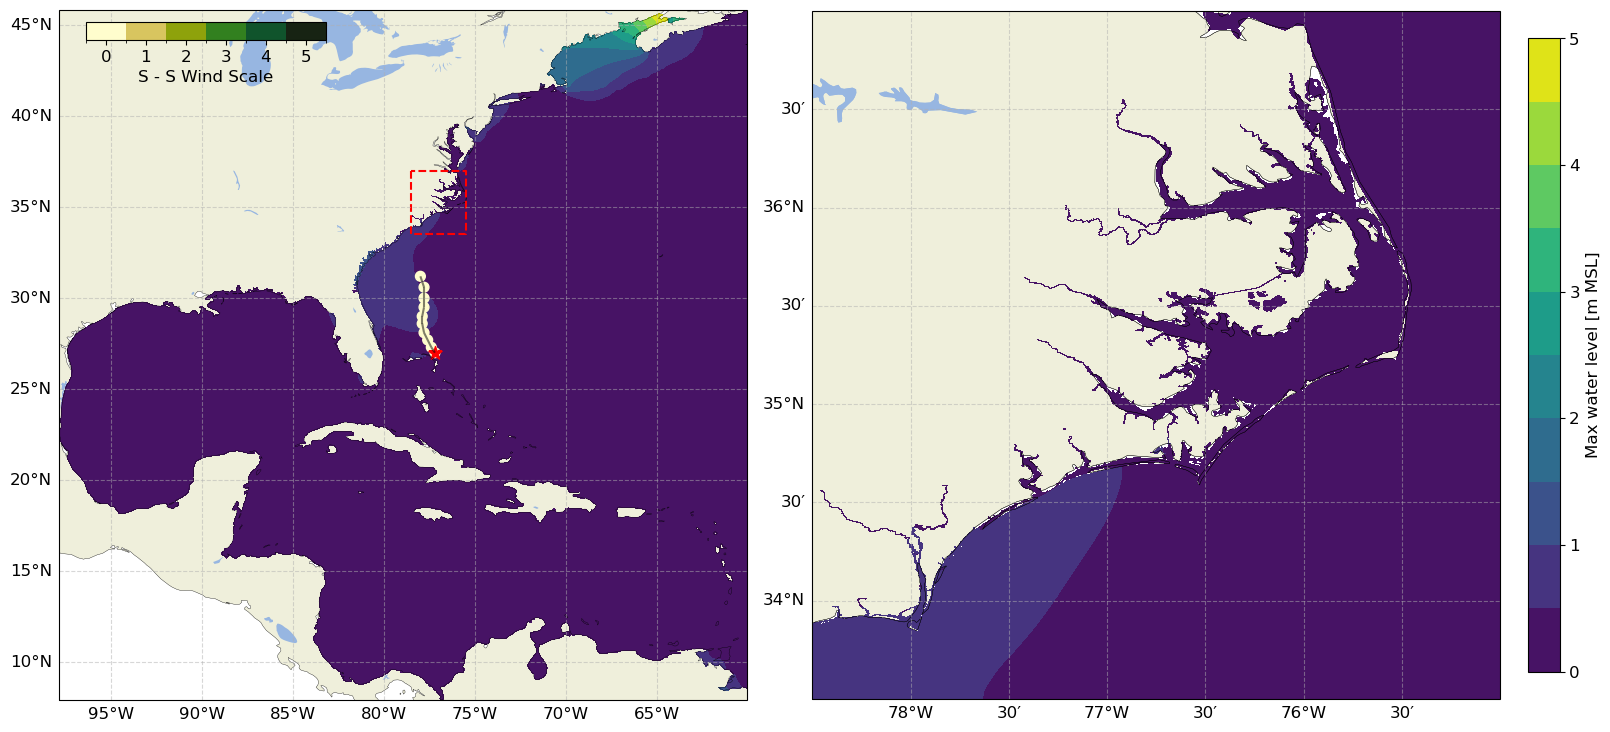

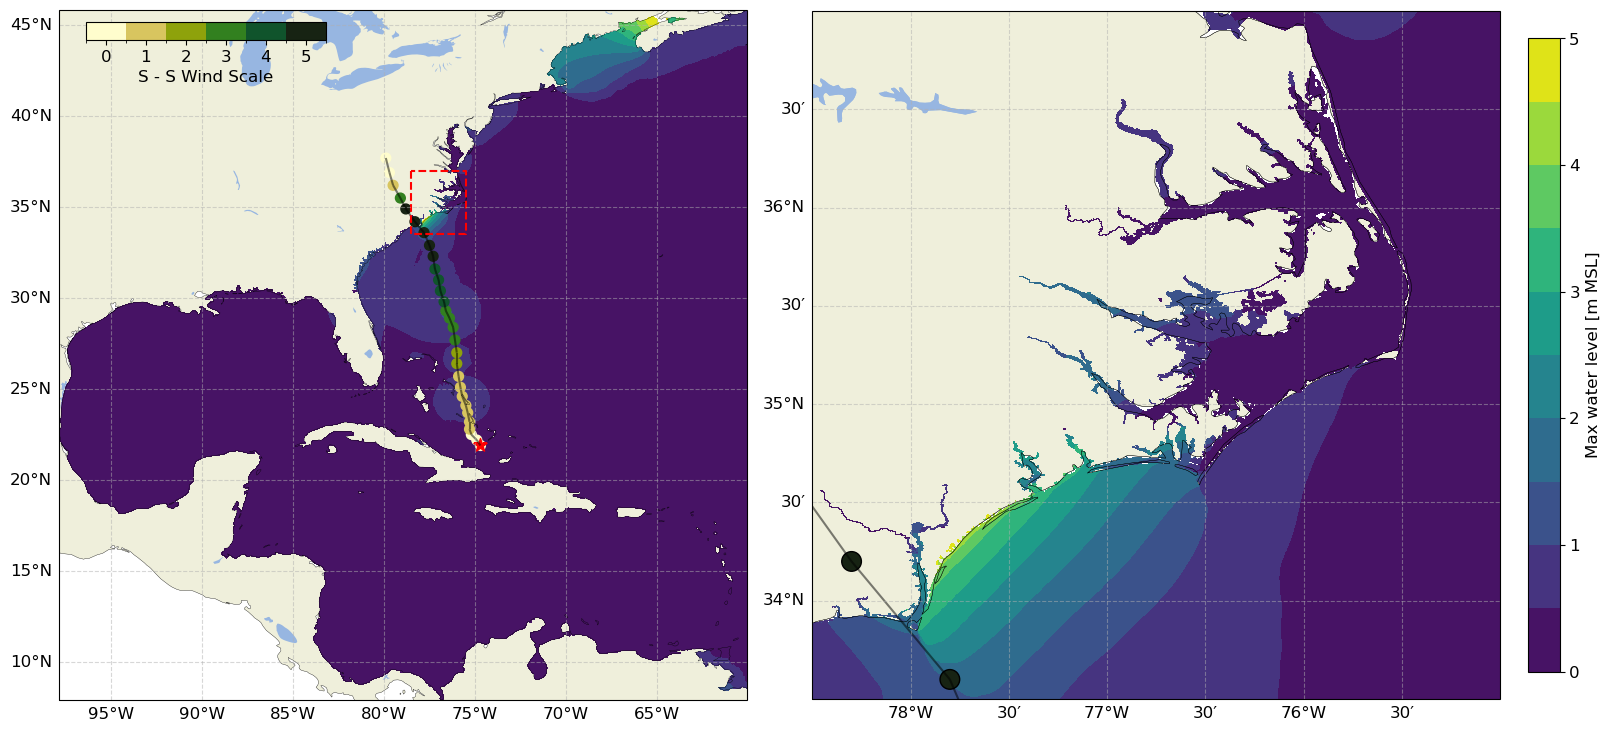

In [6]:
#path = Path(r'/mnt/drive1/Thesis/models/adcirc/concorde_NC9')
# path = Path(r'D:\TCL\ncsu\thesis\adcirc_results')


# pathin = Path(r'/media/tomas/SSD_tomas/thesis/adcirc/batch01/_max_results')
pathin = Path(r'/media/tacuevas/SSD_tomas/thesis/adcirc/batch01/_max_results')
pathout = Path(r'../models/adcirc/concorde_NC9/postprocess')
pathout = pathout/'maxplots'

dfinfo = pd.read_csv(r'../models/adcirc/concorde_NC9/simulations_info_parameters.csv', index_col = 0)

#path_tracks = Path(r'/mnt/drive1/Thesis/data/STORM/processed')
path_tracks = Path(r'../data/STORM/processed')
tracks = pd.read_pickle(path_tracks/'STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000_map_original_ts_v3.pkl')

nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

for x in tqdm(['197', '838']):


    run = pathin/x
    f1 = run/'maxele.63.nc'
    f2 = run/'maxwvel.63.nc'
    nc1 = netcdf.Dataset(f1, 'r')
    nc2 = netcdf.Dataset(f2, 'r')
    storm = tracks[tracks['run_index'] == int(x)]
    info = dfinfo[dfinfo.index == int(x)]

    gdf_track = gpd.GeoDataFrame(geometry = [LineString([[x1, y1], [x2, y2]]) for x1, y1, x2, y2 in zip(storm['lon'].iloc[:-1], 
                                                                                                   storm['lat'].iloc[:-1], 
                                                                                                   storm['lon'].iloc[1:], storm['lat'].iloc[1:])])
    gdf_track['cat'] = storm['cat'].iloc[1:].values
    # cmap = plt.cm.plasma_r
    cmap = cmocean.cm.speed
    #     norm = colors.BoundaryNorm(np.arange(0, storm['cat'].max() + 2, 1), cmap.N)
    norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)
    fig, ax = plt.subplots(figsize = (16, 9), nrows = 1, ncols = 2, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

    ##### subplot 0, 0
    plot2D(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = False, fig = fig, ax = ax[0], cmap = 'viridis')
    #box.boundary.plot(ax = ax[0], color = 'k', ls = '--')
    gdf_track.plot(ax = ax[0], color = 'k', alpha = 0.5)
    ax[0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ax[0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 100)
    ax[0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'r', ls = '--')

    gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[0].add_feature(cfeature.LAND)
    ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0].add_feature(cfeature.LAKES)

    ##### subplot 0, 1
    plot2D_V2(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = True, fig = fig, ax = ax[1], cmap = 'viridis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cax = ax[1], cb_label = 'Max water level [m MSL]')
    gdf_track.plot(ax = ax[1], color = 'k', alpha = 0.5)
    ax[1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 200, edgecolors='k')
    ax[1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 50)
    ax[1].add_feature(cfeature.LAND)
    ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1].add_feature(cfeature.LAKES)

    gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax[1].add_feature(cfeature.LAND)
    ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1].add_feature(cfeature.LAKES)

    fig = ax[0].get_figure()
    cax = fig.add_axes([0.05, 0.85, 0.15, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))

    plt.savefig(pathout/f'Run{x}_adcircMeeting01.png', dpi = 300, bbox_inches = 'tight')

100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


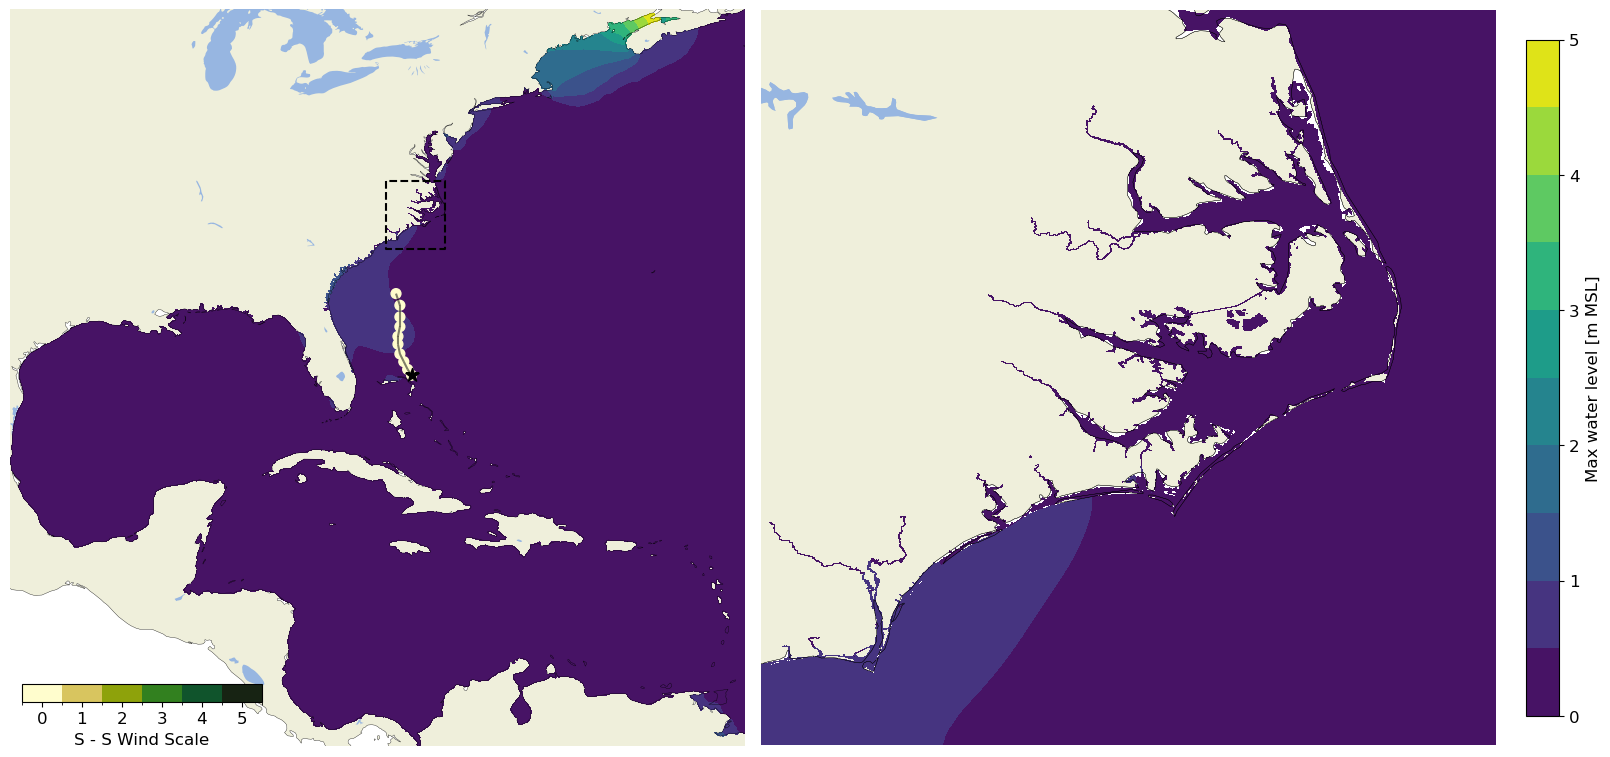

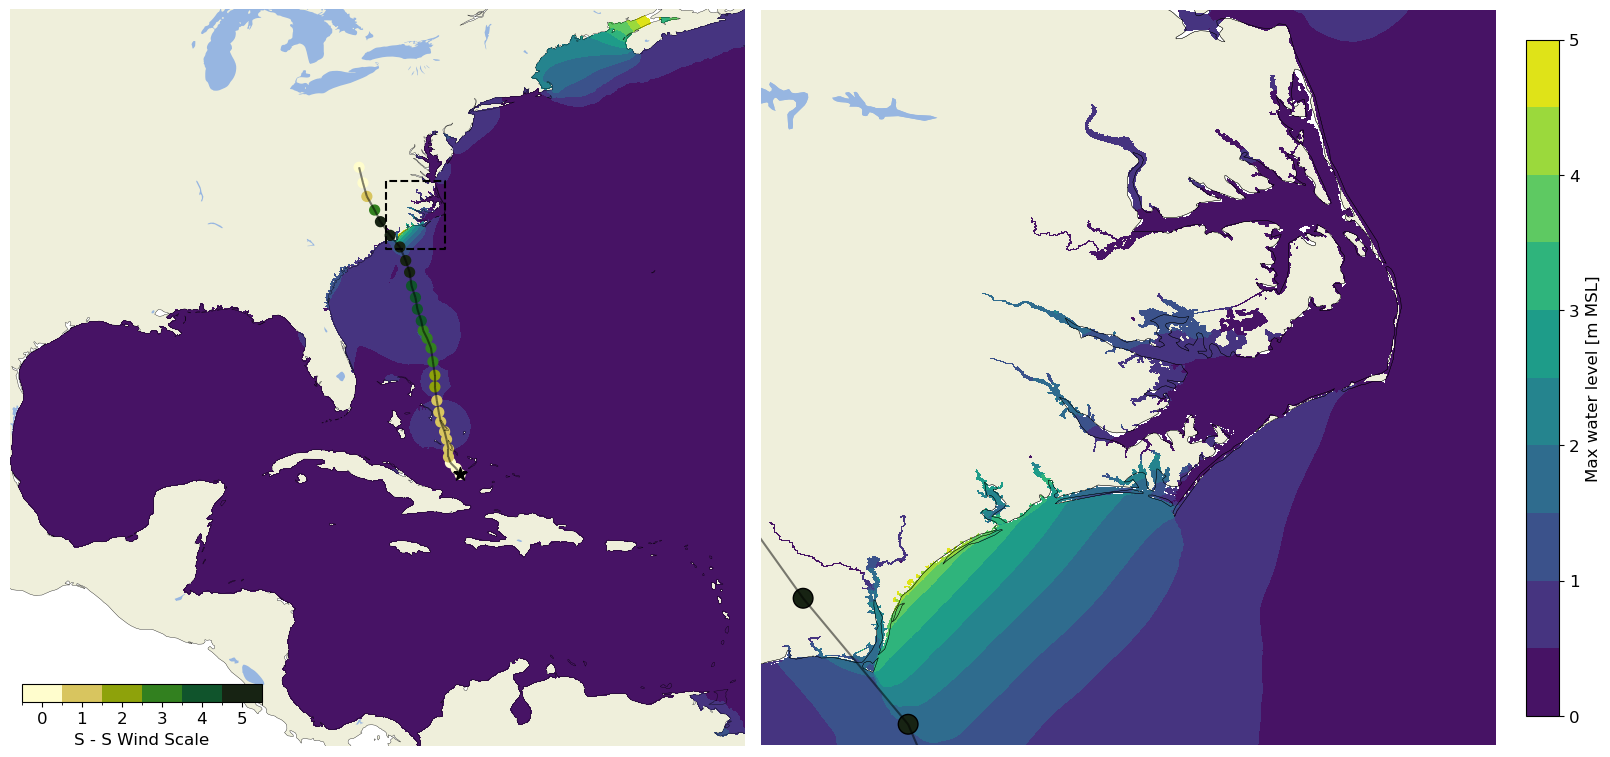

In [5]:
#path = Path(r'/mnt/drive1/Thesis/models/adcirc/concorde_NC9')
# path = Path(r'D:\TCL\ncsu\thesis\adcirc_results')


# pathin = Path(r'/media/tomas/SSD_tomas/thesis/adcirc/batch01/_max_results')
pathin = Path(r'/media/tacuevas/SSD_tomas/thesis/adcirc/batch01/_max_results')
pathout = Path(r'../models/adcirc/concorde_NC9/postprocess')
pathout = pathout/'maxplots'

dfinfo = pd.read_csv(r'../models/adcirc/concorde_NC9/simulations_info_parameters.csv', index_col = 0)

#path_tracks = Path(r'/mnt/drive1/Thesis/data/STORM/processed')
path_tracks = Path(r'../data/STORM/processed')
tracks = pd.read_pickle(path_tracks/'STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000_map_original_ts_v3.pkl')

nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

for x in tqdm(['197', '838']):


    run = pathin/x
    f1 = run/'maxele.63.nc'
    f2 = run/'maxwvel.63.nc'
    nc1 = netcdf.Dataset(f1, 'r')
    nc2 = netcdf.Dataset(f2, 'r')
    storm = tracks[tracks['run_index'] == int(x)]
    info = dfinfo[dfinfo.index == int(x)]

    gdf_track = gpd.GeoDataFrame(geometry = [LineString([[x1, y1], [x2, y2]]) for x1, y1, x2, y2 in zip(storm['lon'].iloc[:-1], 
                                                                                                   storm['lat'].iloc[:-1], 
                                                                                                   storm['lon'].iloc[1:], storm['lat'].iloc[1:])])
    gdf_track['cat'] = storm['cat'].iloc[1:].values
    # cmap = plt.cm.plasma_r
    cmap = cmocean.cm.speed
    #     norm = colors.BoundaryNorm(np.arange(0, storm['cat'].max() + 2, 1), cmap.N)
    norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)
    fig, ax = plt.subplots(figsize = (16, 9), nrows = 1, ncols = 2, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

    ##### subplot 0, 0
    plot2D(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = False, fig = fig, ax = ax[0], cmap = 'viridis')
    #box.boundary.plot(ax = ax[0], color = 'k', ls = '--')
    gdf_track.plot(ax = ax[0], color = 'k', alpha = 0.5)
    ax[0].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)
    ax[0].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 100)
    ax[0].plot([-78.5, -78.5, -75.5, -75.5, -78.5], [37, 33.5, 33.5, 37, 37], c = 'k', ls = '--')

    # gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    # gl.top_labels = False
    # gl.right_labels = False
    ax[0].add_feature(cfeature.LAND)
    ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0].add_feature(cfeature.LAKES)
    ax[0].axis('off')

    ##### subplot 0, 1
    plot2D_V2(nc1, 'zeta_max', np.arange(0, 5.5, 0.5), cbar = True, fig = fig, ax = ax[1], cmap = 'viridis', xlims = [-78.5, -75],
                    ylims = [33.5, 37], cax = ax[1], cb_label = 'Max water level [m MSL]')
    gdf_track.plot(ax = ax[1], color = 'k', alpha = 0.5)
    ax[1].scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 200, edgecolors='k')
    ax[1].scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'k', marker = '*', s = 50)
    ax[1].add_feature(cfeature.LAND)
    ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1].add_feature(cfeature.LAKES)

    # gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    # gl.top_labels = False
    # gl.right_labels = False
    ax[1].add_feature(cfeature.LAND)
    ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1].add_feature(cfeature.LAKES)
    ax[1].axis('off')

    fig = ax[0].get_figure()
    cax = fig.add_axes([0.01, 0.14, 0.15, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))
    

    plt.savefig(pathout/f'Run{x}_adcircMeeting02.png', dpi = 300, bbox_inches = 'tight')